In [2]:
# -*- coding: utf-8 -*-
###
# Demonstration of MR reconstruction with CCP PET-MR Software
#
# This demonstration shows how to reconstruct MR images on a coil-by-coil basis
# and how to combine the image information from the different receiver coils
#
# This demo is a 'script', i.e. intended to be run step by step in a
# Python IDE such as spyder. It is organised in 'cells'. spyder displays these
# cells nicely and allows you to run each cell on its own.
#
# First version: 27th of May 2017
# Updated 10th of April 2019
# Author: Christoph Kolbitsch, Johannes Mayer
#

## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.

## Coil Combination Methods
### Goals of this notebook:
- Explore ways to combine acquisition data from multiple receiver coils.

In [19]:
__version__ = '0.1.0'

# import engine module
import sirf.Gadgetron as pMR
from sirf.Utilities import examples_data_path

# import further modules
import os, numpy
%matplotlib
import matplotlib.pyplot as plt

#%% GO TO MR FOLDER
os.chdir( examples_data_path('MR'))

Using matplotlib backend: Qt5Agg


### Multi Receiver Channel Imaging
In principle one does not need multiple coils placed on a patient or phantom in an MR exam. Every scanner has the so called body coil which is able to receive the MRI signal and one can reconstruct an image from that.

However, nobody uses the body coil images any more but so called __receiver coils__ somethimes refered to as __phased arrays__ or mostly just as __coils__ are used. This has several advantages, one being that the receiver can be placed very close to the recorded signal.   
Each of this channels also adds a complex phase onto the recorded signal (hence the name __phased__ arrays!)

The sensitivity of these phased arrays is not constant but a function of space. The different coils are also referred to as __channels__.

#### Naming Convention
The following expressions are usually used synonymously:
- coil sensitivity profile
- coil sensitivity maps (CSM)
- coil maps

In [4]:
#%% LOAD AND PREPROCESS RAW MR DATA
filename = 'ptb_resolutionphantom_fully_ismrmrd.h5'
acq_data = pMR.AcquisitionData(filename)
preprocessed_data = pMR.preprocess_acquisition_data(acq_data)
preprocessed_data.sort()



In [5]:
#%% RETRIEVE K-SPACE DATA
k_array = preprocessed_data.as_array()
print('Size of k-space %dx%dx%d' % k_array.shape)




Size of k-space 256x4x256


Size of k-space 256x4x256


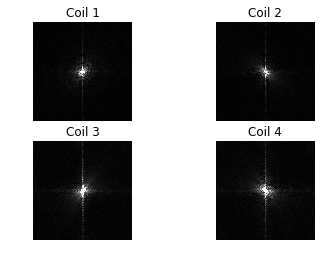

In [6]:
#%% SELECT FIRST REPETITION AND VIEW DATA
k_array = k_array[0:256,:,:]
print('Size of k-space %dx%dx%d' % k_array.shape)

k_array = k_array / numpy.max(abs(k_array[:]))
num_channels = k_array.shape[1]

fig = plt.figure(1)
plt.set_cmap('gray')
for c in range( num_channels ):
    ax = fig.add_subplot(2,num_channels/2,c+1)
    ax.imshow(abs(k_array[:,c,:]), vmin=0, vmax=0.05)
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')




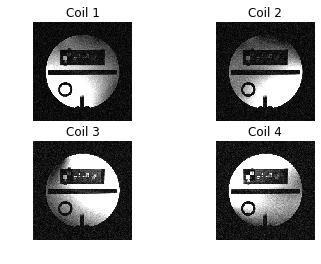

In [7]:
#%% APPLY INVERSE FFT TO EACH COIL AND VIEW IMAGES
image_array = numpy.zeros(k_array.shape, numpy.complex128)
for c in range(k_array.shape[1]):
    image_array[:,c,:] = numpy.fft.fftshift(numpy.fft.ifft2(numpy.fft.ifftshift(k_array[:,c,:])))
image_array = image_array/image_array.max()
   

fig = plt.figure(2)   
plt.set_cmap('gray')
for c in range(image_array.shape[1]):
    ax = fig.add_subplot(2,num_channels/2,c+1)
    ax.imshow(abs(image_array[:,c,:]), vmin=0, vmax=0.4)
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')
    
    


### Question:
- What differences appear in the individual channel reconstructions compared to the combined image we saw in the last notebook?


### Sum of Square (SOS) Coil Combination

As you can see the individual receiver channels have a spatially varying intensity due to the coil sensitivity profiles. This information needs to be combined.

Assume you have a set of reconstructed images $f_c$ where $c \in \{1, \dots N_c \}$ label the individual coil channels' reconstructions.

One way to combine the signal from all coil channels is to use a sum-of-squares approach:

$$
f_{sos} = \sqrt{ \sum_c \bigl{|} \, f_c \bigr{|}^2 }
$$

### Question:
- Why is SOS preferable to simply summing them without squaring: $\;f_{combined} = \sum_c f_c$
- What could be a possible disadvantage of this coil combination approach?
- Apart from fancy parallel imaging techniques, why is it even useful to have more than one receiver channel?  

Text(0.5, 1.0, 'Combined image using sum-of-squares')

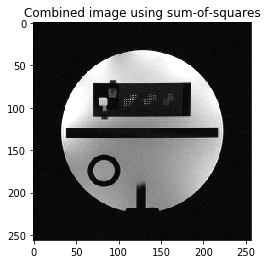

In [8]:
#%% COMBINE COIL IMAGES USING SOS
image_array_sos = numpy.sqrt(numpy.sum(numpy.square(numpy.abs(image_array)),1))
image_array_sos = image_array_sos/image_array_sos.max()

fig = plt.figure(3)
plt.set_cmap('gray')
plt.imshow(image_array_sos, vmin=0, vmax=0.7)
plt.title('Combined image using sum-of-squares') 




### Weighted Sum (WS) Coil Combination

Instead of squaring each channel before adding them up there is another method of combining coils, by weighting each image with it's corresponding coil sensitivity:

One way to combine the signal from all coil channels is to use a sum-of-squares approach:

$$
f_{ws} =  \frac{1}{{\sum_{c'}{\bigl{|} C_{c'} \bigr{|}^2}}}{\sum_c C_c^* \cdot f_c}
$$
where $C_c$ is the coil sensitivity profile of coil $c$.  

It can be shown that this way of combining coils yields an optimal signal-to-noise ratio (SNR). Note also, that this way of combining channels does not destroy the phase information.
However, for each coil one needs to either
- estimate the coil sensitivity $C_c$ from the data itself.
- measure them separately (clinically not feasible).

For the task of estimating coil sensitivities from the acquisition data, in `pMR` there is a class called `CoilSensitivityData`. Let's use it to compute the coilmaps of our dataset. __Note:__ the details of the the coilmap estimation is outside the scope of this workshop.

### Computing Coil Sensitivities



In [16]:
#%% CALCULATE COIL SENSITIVITIES
csm = pMR.CoilSensitivityData()
#help(csm)

csm.smoothness = 100
csm.calculate(preprocessed_data,method = 'Inati()')

In [20]:
# Cell plotting the Coilmaps
csm_array = numpy.squeeze(csm.as_array(0))

# csm_array has orientation [coil, im_x, im_y]
csm_array = csm_array.transpose([1,0,2])

fig = plt.figure()
plt.set_cmap('jet')
for c in range(num_channels):
    ax = fig.add_subplot(2,num_channels,c+1)
    ax.imshow(abs(csm_array[:,c,:]))
    ax.set_title('Coil '+str(c+1))
    ax.axis('off')

### Question
Please answer the following questions:
- Why is there so much noise in some regions of the coilmaps and outside the object? 
- Is this noise in the coilmap going to have a strong negative impact on the image quality in this region of the combined image?
- In which organ in the human anatomy would you expect a coilmap to look similarly noisy?



In [21]:
#%% COMBINE COIL IMAGES USING WEIGHTED SUM
image_array_ws = numpy.sum(numpy.multiply(image_array, numpy.conj(csm_array)),1)
image_array_ws = abs(numpy.divide(image_array_ws, numpy.sum(numpy.multiply(csm_array, numpy.conj(csm_array)),1)))
image_array_ws = image_array_ws/image_array_ws.max()


diff_img_arr = abs(image_array_sos-image_array_ws)
diff_img_arr = diff_img_arr/diff_img_arr.max()


fig = plt.figure(figsize=[12, 4])
plt.set_cmap('gray')

ax = fig.add_subplot(1,3,1)
ax.imshow(image_array_sos, vmin=0, vmax=0.7)
ax.set_title('Sum-of-squares (SOS)')
ax.axis('off')

ax = fig.add_subplot(1,3,2)
ax.imshow(image_array_ws, vmin=0, vmax=0.7)
ax.set_title('Weighted sum (WS)')
ax.axis('off')

ax = fig.add_subplot(1,3,3)
ax.imshow(diff_img_arr, vmin=-0, vmax=0.1)
ax.set_title('SOS - WS')
ax.axis('off')





(-0.5, 255.5, 255.5, -0.5)

### Question

Do you think instead of reconstructing individual coil channels and combining them there is a possibility to reconstruct them all together into one image at the same time?


### Recap Coil Combination

In this exercise we learned:
- how to combine multichannel image reconstructions
- compute coil sensitivities with SIRF.




In [ ]:
plt.close('all')